# IEEE_UNet 모델 만들어 보기
---
1. import module
2. Device Check
3. Data Load
4. Data Check(1)
5. Data Check(2)
6. IEEE_UNet 모델 설계
7. Optimizer, Objective Function 설정
8. Train 데이터 모델 성능 확인
9. Valid 데이터 모델 성능 확인
10. CNN 실행하면서 Train, Test의 Loss 및 Accuracy 확인

# 1.import module

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# 2.Device Check

In [2]:
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
print(f"Pytorch Version: {torch.__version__} \t Device: {DEVICE}")

BATCH_SIZE = 1
EPOCHS = 5

img_path = "D:/data/도로장애물·표면 인지 영상(수도권)/Training/Images/CRACK/C_Frontback_D01/"
ann_path = "D:/data/도로장애물·표면 인지 영상(수도권)/Training/Annotations/CRACK/C_Frontback_D01/"

Pytorch Version: 1.10.1 	 Device: cuda


In [3]:
import os
from os.path import splitext
from pathlib import Path

test_x = Path(img_path)
ids = [splitext(file)[0] for file in os.listdir(img_path) if not file.startswith('.')]

## `pathlib.Path`
---
- 객체 지향 파일 시스템 경로
- 다른 운영체제에서 동일하게 경로를 접근할 수 있음
    > 참고 : [pathlib.Path에 대한 자세한 사항](https://docs.python.org/ko/3/library/pathlib.html)

# 3.Data Load

In [4]:
import logging
import torch

from PIL import Image
from pathlib import Path
from os import listdir
from os.path import splitext
from torch.utils.data import Dataset


class BaseDataset(Dataset):
    def __init__(self, img_path: str, ann_path: str, scale: float=1.0, ann_suffix: str= ''):
        self.img_path = Path(img_path)
        self.ann_path = Path(ann_path)
        
        assert 0 < scale <= 1, "Scale은 0과 1 사잇값이어야 합니다."
        self.scale = scale
        self.ann_suffix = ann_suffix
        
        self.ids = [splitext(file)[0] for file in listdir(img_path) if not file.startswith('.')]
        if not self.ids:
            raise RuntimeError(f"{img_path}\n 위 경로를 찾을 수 없습니다.")
        logging.info(f"Creating dataset with {len(self.ids)} examples")
        
    def __len__(self):
        return len(self.ids)
    
    @classmethod
    def preprocess(cls, pil_img, scale, is_ann):
        w, h = pil_img.size
        trs_w, trs_h = int(scale*w), int(scale*h)
        
        assert trs_w>0 and trs_h>0, "스케일이 너무 작습니다. 다시 조정해 주세요."
        pil_img = pil_img.resize((trs_w, trs_h), resample=Image.NEAREST if is_ann else Image.BICUBIC)
        
        """
        여기서부터 이해가 안됨
        """
        img_ndarray = np.asarray(pil_img)                   # 이미지 arr 생성
        
        if img_ndarray.ndim==2 and not is_ann:              # 이미지 arr 차원수==2 and "ann"이 아닐 때
            img_ndarray = img_ndarray[np.newaxis, ...]      # 이미지 arr = 이미지 arr에서 np.newaxis부터의 arr
            # --> 3차원으로 변환해 주는 것 같다 (np.newaxis는 차원을 변환할 때 사용됨)
            
        # elif not is_ann:                                    # "ann"이 아닐 때
        img_ndarray = img_ndarray.transpose((2, 0, 1))  # 3차원이니깐 0,1,2 -> 2,0,1 순서로 변환
        # --> 정확히는 모르겠지만 (H,W,C) -> (C,H,W) 인 것 같기도,,? 나중에 정확히 확인
            
        if not is_ann:
            img_ndarray = img_ndarray/255
        
        return img_ndarray
    
    @classmethod
    def load(cls, filename):                # 데이터 로드  함수
        ext = splitext(filename)[1]         # 확장자를 확인하는 라인
        if ext in ['.npz', '.npy']:         # .npz, .npy로 끝나면 numpy로 받아옴
            return Image.fromarray(np.load(filename))
        elif ext in ['.pt', '.pth']:        # .pt, .pth로 끝나면 torch로 받아와서 numpy로 변환                         
            return Image.fromarray(torch.load(filename).numpy())
        else:
            return Image.open(filename)     # 이외의 확장자는 그냥 가져옴

    def __getitem__(self,idx):
        name = self.ids[idx]
        ann_file = list(self.ann_path.glob(name+self.ann_suffix+'.png'))
        img_file = list(self.img_path.glob(name+".png"))
        
        assert len(ann_file)==1, f"어노테이션이 없거나, 여러 개의 ID를 지녔습니다. {name}: {ann_file}"
        assert len(img_file)==1, f"이미지가 없거나, 여러 개의 ID를 지녔습니다. {name}: {img_file}"
        
        annot = self.load(ann_file[0])
        img = self.load(img_file[0])
        
        assert img.size == annot.size, \
            '이미지와 어노테이션의 {name}은 반드시 같아야 합니다, 지금은 이미지 {img.size} 와 어노테이션 {annot.size}로 다릅니다.'
            
        img = self.preprocess(img, self.scale, is_ann=False)
        annot = self.preprocess(annot, self.scale, is_ann=True)
        
        return {
            "image" : torch.as_tensor(img.copy()).float().contiguous(),
            "annot" : torch.as_tensor(annot.copy()).long().contiguous()
        }
        
class CrackDataset(BaseDataset):
    def __init__(self, img_path, ann_path, scale=1):
        super().__init__(img_path, ann_path, scale, ann_suffix='_PLINE')

"""
#################################################
Class 정의 후 데이터 로딩해서 확인해 볼 필요가 있음
#################################################
"""

from torch.utils.data import DataLoader, random_split

# 1. Create dataset
dir_img = img_path
dir_mask = ann_path
img_scale = .5
val_percent = .2


try:
    dataset = CrackDataset(dir_img, dir_mask, img_scale)
except (AssertionError, RuntimeError):
    dataset = BaseDataset(dir_img, dir_mask, img_scale)

# 2. Split into train / validation partitions
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

# 3. Create data loaders
loader_args = dict(batch_size=BATCH_SIZE,
                #    num_workers=4, 
                #    pin_memory=True
                   )
train_loader = DataLoader(train_set, shuffle=True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

**새로운 코드 라인**
---
- `pathlib.Path`
- `os.path.splitext`
- `os.listdir().startswith()`
- `logging`
- `assert`
- `@classmethod`
- `np.ndarray[np.newaxis, ...]`
- `np.ndarray.transpose((a,b,c))`
- `pathlib.Path.glob`

# 4.Data Check(1)

In [9]:
for check in train_loader:
    print("images: ", check["image"].shape)
    print("annotations: ", check["annot"].shape)
    
    print(f"\n{check['image'][0].shape}")
    print(f"{check['annot'][0].shape}")
    break

images:  torch.Size([1, 3, 360, 640])
annotations:  torch.Size([1, 3, 360, 640])

torch.Size([3, 360, 640])
torch.Size([3, 360, 640])


# 5.Data Check(2)

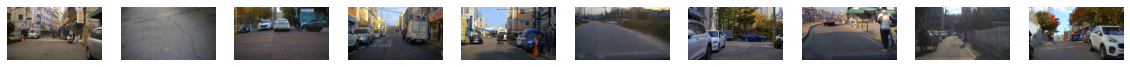

In [10]:
pltSize=2
plt.figure(figsize=(10*pltSize, pltSize))

for i, check in enumerate(train_loader):
    if i==10: break
    # print(i)
    # print(check["image"].shape)
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(check["image"][0], (1,2,0)))
    
    # plt.title(f"Class: {y_train[i].item()}")

# 6.IEEE UNet 모델 설계

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels = 3,
            out_channels = 8,
            kernel_size = 3,
            padding = 1
        )
        self.conv2 = nn.Conv2d(
            in_channels = 8,
            out_channels = 16,
            kernel_size = 3,
            padding = 1
        )
        self.pool = nn.MaxPool2d(
            kernel_size = 2,
            stride = 2
        )
        self.fc1 = nn.Linear(8*8*16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        # Convolution Layer & Pooling Layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Fully Connected Layer
        x = x.view(-1, 8*8*16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        
        return x
        

# 7.Optimizer, Objective Function 설정

In [ ]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
criterion = nn.CrossEntropyLoss()
print(model)

# 8.Train Data 모델 성능 확인

In [ ]:
def train(model, train_loader, optimizer, log_interval):
    model.train
    for batch_idx,(image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        
        optimizer.zero_grad()
        output = model(image)
        
        loss = criterion(output, label)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(Epoch, batch_idx*len(image),
                                                                                 len(train_loader.dataset), 100.*batch_idx/len(train_loader),
                                                                                 loss.item()))

# 9.Valid Data 모델 성능 확인

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    
    test_loss=0
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            
            test_loss += criterion(output, label).item()
            
            prediction = output.max(1, keepdim=True)[1]
            
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# 10.CNN 실행하면서 Train, Test의 Loss 및 Accuracy 확인

In [ ]:
from tqdm.notebook import tqdm as n_tqdm
from tqdm import tqdm as t_tqdm

for Epoch in t_tqdm(range(1, EPOCHS+1)):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".
    format(Epoch, test_loss, test_accuracy))